In [1]:
%load_ext autoreload

%autoreload 2

In [48]:
from itertools import combinations_with_replacement, product

import matplotlib.pyplot as plt
import numpy as cp
import numpy as np
import qutip as qt
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from qcheff.duffing.duffing_chain_utils import (
    create_uneven_Duffing_Chain,
    duffing_chain_num_ham,
)

rng = cp.random.default_rng()

import matplotlib as mpl
from matplotlib.colors import LogNorm

from qcheff.duffing.duffing_chain_utils import create_duffing_chain_zz_system
from qcheff.npad.sparse.npad_cpu import (
    npad_decouple,
    npad_diagonalize,
    npad_eliminate_couplings_simultaneous,
)

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 20


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH.get(), cmap="binary", norm=LogNorm(vmin=1e-10) if scale == "log" else None
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)


mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["text.usetex"] = False
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams["axes.titlesize"] = 20

In [22]:
delp = 0.1
delm = 0.3
global_chain_size = 3
global_ntrunc = 3
system_dims = [global_ntrunc] * global_chain_size
example_chain = create_duffing_chain_zz_system(
    chain_size=global_chain_size,
    delp=delp,
    delm=delm,
    ntrunc=global_ntrunc,
)

AttributeError: 'numpy.ndarray' object has no attribute 'get'

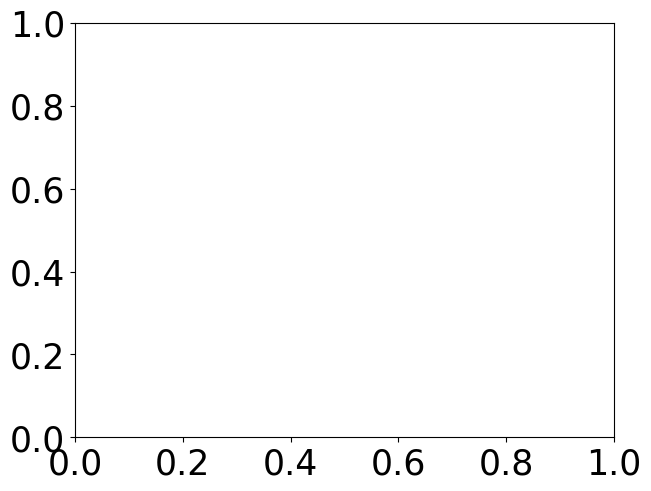

In [36]:
chain_full_ham = cp.asarray(duffing_chain_num_ham(example_chain).toarray())
plot_offdiag_mag(chain_full_ham)

# Duffing Chain ZZ Example NPAD
We will estimate the zz coupling between the qubits at the two ends of a linear spin chain.

There are 3^5 = 243 levels in this chain of size 5. We only care about the levels contributing to ZZ interaction for the end qubits. there are 4 such levels.
We should partition them out.

In [37]:
all_levels = list(qt.state_number_enumerate(system_dims))
# Keeping levels with 0 or 1 excitations at the ends, and 0 excitations in the middle
end_zz_levels = [
    label
    for label in all_levels
    if label[0] in [0, 1] and label[-1] in [0, 1] and set(label[1:-1]) == {0}
]
# qubit_chain_levels = [label for label in all_levels if max(label) <= 1]
other_levels = [label for label in all_levels if label not in end_zz_levels]
end_zz_idx = cp.asarray(
    [qt.state_number_index(system_dims, state) for state in end_zz_levels]
)
other_idx = cp.asarray(
    [qt.state_number_index(system_dims, state) for state in other_levels]
)

In [38]:
end_zz_levels

[(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1)]

Now, we can construct sets of couplings to rotate away simulatneously. We will bunch the couplings by photon number. 

In [39]:
# This hamiltonian is photon number preserving for total photons.
all_couplings = [
    (lev1, lev2)
    for lev1, lev2 in (list(product(end_zz_levels, other_levels)))
    if sum(lev1) == sum(lev2)
]
all_couplings

[((0, 0, 1), (0, 1, 0)),
 ((1, 0, 0), (0, 1, 0)),
 ((1, 0, 1), (0, 0, 2)),
 ((1, 0, 1), (0, 1, 1)),
 ((1, 0, 1), (0, 2, 0)),
 ((1, 0, 1), (1, 1, 0)),
 ((1, 0, 1), (2, 0, 0))]

It might be hard to classify them, so maybe  we should generate them instead. The easiest way would be to create the generator, then get multi-photon couplings from combinations of that.

In [40]:
pm_gens = cp.asarray(
    cp.identity(global_chain_size) - cp.diag(cp.ones(global_chain_size - 1), k=1),
    dtype=int,
)[:-1]
mp_gens = -pm_gens
all_1p_gens = cp.vstack([pm_gens, mp_gens])
all_1p_gens

array([[ 1, -1,  0],
       [ 0,  1, -1],
       [-1,  1,  0],
       [ 0, -1,  1]])

In [41]:
all_2p_gens = cp.vstack(
    [sum(gens) for gens in combinations_with_replacement(all_1p_gens, 2)]
)
all_2p_gens

array([[ 2, -2,  0],
       [ 1,  0, -1],
       [ 0,  0,  0],
       [ 1, -2,  1],
       [ 0,  2, -2],
       [-1,  2, -1],
       [ 0,  0,  0],
       [-2,  2,  0],
       [-1,  0,  1],
       [ 0, -2,  2]])

So we should now apply these transitions and get the result states

In [42]:
cp.vstack(end_zz_levels)

array([[0, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 1]])

In [43]:
fstates = cp.vstack(end_zz_levels)[:, None, :] + all_2p_gens
istates = cp.broadcast_to(cp.vstack(end_zz_levels)[:, None, :], fstates.shape)

coupling_tuples = [
    (istate, fstate)
    for istate, fstate in zip(cp.vstack(istates), cp.vstack(fstates), strict=False)
    if cp.all(fstate >= 0)
    and cp.all(fstate < global_ntrunc)
    and not cp.all(fstate == 0)
]

coupling_tuples

[(array([0, 0, 1]), array([1, 0, 0])),
 (array([0, 0, 1]), array([0, 0, 1])),
 (array([0, 0, 1]), array([0, 0, 1])),
 (array([1, 0, 0]), array([1, 0, 0])),
 (array([1, 0, 0]), array([1, 0, 0])),
 (array([1, 0, 0]), array([0, 0, 1])),
 (array([1, 0, 1]), array([2, 0, 0])),
 (array([1, 0, 1]), array([1, 0, 1])),
 (array([1, 0, 1]), array([0, 2, 0])),
 (array([1, 0, 1]), array([1, 0, 1])),
 (array([1, 0, 1]), array([0, 0, 2]))]

Now we can try finding the indices for these coupling terms.

In [44]:
# We will deliberately ignore the diagonal elements
coupling_idx = cp.asarray(
    [
        (qt.state_number_index(system_dims, i), qt.state_number_index(system_dims, j))
        for i, j in coupling_tuples
        if (i - j).any()
    ]
)
coupling_idx

array([[ 1,  9],
       [ 9,  1],
       [10, 18],
       [10,  6],
       [10,  2]])

We can now formalize this in a function.

In [45]:
def get_n_photon_couplings(n: int):
    pm_gens = cp.asarray(
        cp.identity(global_chain_size) - cp.diag(cp.ones(global_chain_size - 1), k=1),
        dtype=int,
    )[:-1]
    mp_gens = -pm_gens
    all_1p_gens = cp.vstack([pm_gens, mp_gens])
    all_np_gens = cp.vstack(
        [sum(gens) for gens in combinations_with_replacement(all_1p_gens, n)]
    )
    fstates = cp.vstack(end_zz_levels)[:, None, :] + all_np_gens
    istates = cp.broadcast_to(cp.vstack(end_zz_levels)[:, None, :], fstates.shape)

    coupling_tuples = [
        (istate, fstate)
        for istate, fstate in zip(cp.vstack(istates), cp.vstack(fstates), strict=False)
        if cp.all(fstate >= 0)
        and cp.all(fstate < global_ntrunc)
        and not cp.all(fstate == 0)
    ]

    coupling_idx = cp.asarray(
        [
            (
                qt.state_number_index(system_dims, i),
                qt.state_number_index(system_dims, j),
            )
            for i, j in coupling_tuples
            if (i - j).any()
        ]
    )
    return np.unique(coupling_idx, axis=0)


get_n_photon_couplings(7)

array([[ 1,  3],
       [ 1,  3],
       [ 1,  3],
       [ 1,  3],
       [ 9,  3],
       [ 9,  3],
       [ 9,  3],
       [ 9,  3],
       [10, 12],
       [10,  4],
       [10, 12],
       [10,  4],
       [10, 12],
       [10,  4],
       [10, 12],
       [10,  4]])

In [46]:
np.unique(get_n_photon_couplings(7), axis=0)

array([[ 1,  3],
       [ 9,  3],
       [10,  4],
       [10, 12]])

Now that we have identified labels for each set of levels, we first decouple, then diagonalize.).

In [49]:
def npad_auto_chain_zz(delp, delm):
    test_sys = create_duffing_chain_zz_system(
        chain_size=global_chain_size,
        delp=delp,
        delm=delm,
        ntrunc=global_ntrunc,
    )
    system_dims = [global_ntrunc] * global_chain_size
    all_levels = list(qt.state_number_enumerate(system_dims))
    end_zz_levels = [
        label
        for label in all_levels
        if label[0] in [0, 1] and label[-1] in [0, 1] and set(label[1:-1]) == {0}
    ]
    other_levels = [label for label in all_levels if label not in end_zz_levels]
    end_zz_idx = cp.asarray(
        [qt.state_number_index(system_dims, state) for state in end_zz_levels]
    )
    other_idx = cp.asarray(
        [qt.state_number_index(system_dims, state) for state in other_levels]
    )
    test_ham = cp.asarray(duffing_chain_num_ham(test_sys)[:])
    # This can get really slow.
    coupling_batches = [get_n_photon_couplings(n) for n in range(1, global_chain_size)]
    for batch in coupling_batches:
        test_ham = npad_eliminate_couplings_simultaneous(test_ham, batch)
    npad_cz_ham = npad_diagonalize(test_ham[cp.ix_(end_zz_idx, end_zz_idx)], eps=1e-12)
    E00, E01, E10, E11 = cp.diag(npad_cz_ham)
    return E11 + E00 - E01 - E10


npad_auto_chain_zz(0.1, 0.3)

IndexError: tuple index out of range

In [ ]:
N = 50
delp_list = cp.linspace(-0.9, 0.4, N)
delm_list = cp.linspace(-0.5, 0.5, N)


npad_auto_chain_zz_list = cp.vstack(
    Parallel(n_jobs=-2, verbose=0)(
        delayed(npad_auto_chain_zz)(delp, delm)
        for delm, delp in tqdm(
            product(delm_list, delp_list),
            total=(delm_list.shape[0] * delp_list.shape[0]),
        )
    )
).get()

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, '$|\\zeta|$ (MHz)')

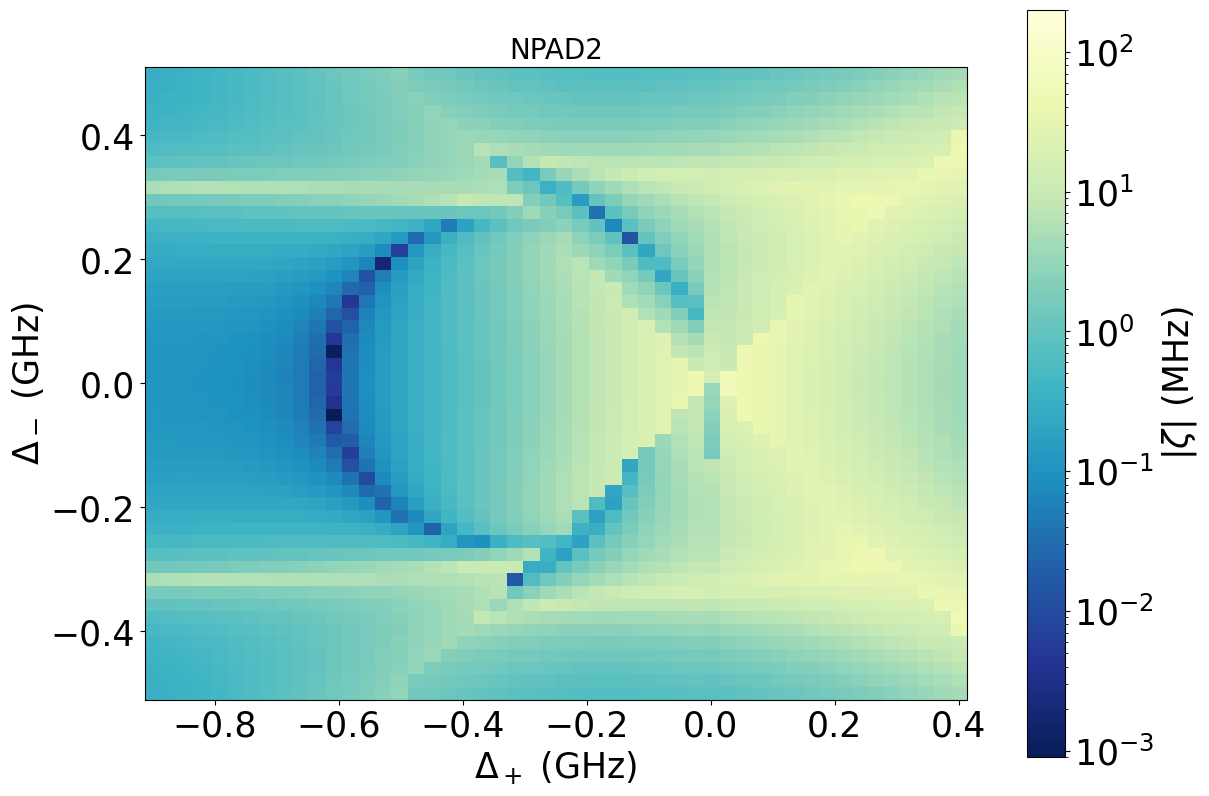

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    layout="constrained",
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
pm2 = ax.pcolormesh(
    delp_list.get(),
    delm_list.get(),
    np.abs(npad_auto_chain_zz_list.reshape(delm_list.shape[0], delp_list.shape[0]))
    * 1e3,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(vmin=9e-4, vmax=2e2),
)
ax.set(
    title="NPAD2",
    aspect="equal",
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\Delta_-$ (GHz)",
)

cbar = fig.colorbar(pm2)
cbar.ax.set_ylabel(r"$|\zeta|$ (MHz)")